In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
# IGNORE THIS FILE for now
# This emsures that our results are predictable
torch.manual_seed(1)
np.random.seed(1)

#  Loading Data
First we will load the MNIST data. 

(60000, 28, 28)


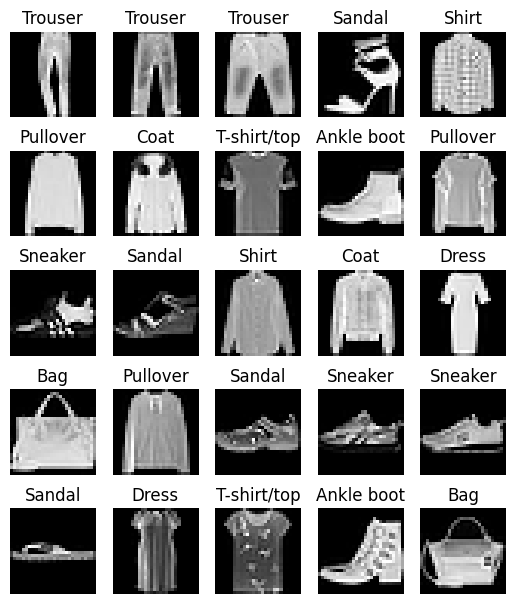

In [2]:
# np.random.seed(10)
train_images, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
print(train_images.shape)
# Do the same loading of data for the test data as well.
######### YOUR CODE HERE #########
test_images, test_labels = zip(*torchvision.datasets.FashionMNIST(".", train=False, download=True))
test_images = np.asarray([np.array(img) for img in test_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)

################################
# Normalize images so values are between 0 and 1

######### YOUR CODE HERE #########
train_images = train_images/255
test_images = test_images/255
# print(train_images[0])
################################

# Dataloaders
batch_size = 512
train_loader = DataLoader(dataset=(train_images, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=(test_images, test_labels), batch_size=batch_size, shuffle=True)

# Labels are given as numbers from 0 to 9. Each number corresponds to class_names[number]
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

# Using matplotlib library visualize a randon subset of 25 images from the training dataset with their corresponding labels as the titles for the plots.
# Hint: Use subplot function.

######### YOUR CODE HERE #########
img_indices = np.array([np.random.randint(0, len(train_images)) for i in range(25)])
fig, axes = plt.subplots(5, 5)
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    img = train_images[i]
    axes[n//5, n%5].axis('off')
    axes[n//5, n%5].imshow(img, cmap='gray')
plt.subplots_adjust(bottom=0, top=1.2)
################################

# Non Spiking Model
Next we’ll build and train a simple non-spiking model to classify the MNIST images.

In [3]:
# Create a model where you define the neural network using PyTorch library. 
# The dataset is Fashion MNIST, whose images are of the size 28*28.
# Create only one hidden layer for the task. 
# The Fashion MNIST has 10 classes that it predicts.

######### YOUR CODE HERE #########
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        logits = self.activation(x)
        return logits
model = NeuralNetwork()
################################

In [4]:

def train(input_model, train_x, test_x):
    # minibatch_size = 32
    optimizer = torch.optim.SGD(input_model.parameters(), lr=0.01)

    input_model.train()
    for j in range(10):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_model.zero_grad()

            batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_model(torch.tensor(batch_in))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()
            if i==0: print(loss)
            loss.backward()
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print(f"Train accuracy ({j}): {train_acc.numpy()}")

    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1
    print(f"Test accuracy: {test_acc.numpy()}")

In [5]:
train_x = train_images
minibatch_size = 100
i = 1
batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
# batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
print(batch_in.shape)
print(train_x.shape[1:-1])

(100, 28, 28)
(28,)


In [6]:
# Call the train function and train on the dataset.
######### YOUR CODE HERE #########

train(model, train_images, test_images)
    
################################

tensor(2.2998, grad_fn=<NegBackward0>)
Train accuracy (0): 0.6295003294944763
tensor(0.8276, grad_fn=<NegBackward0>)
Train accuracy (1): 0.740183413028717
tensor(0.6230, grad_fn=<NegBackward0>)
Train accuracy (2): 0.7786327600479126
tensor(0.5338, grad_fn=<NegBackward0>)
Train accuracy (3): 0.800482451915741
tensor(0.4802, grad_fn=<NegBackward0>)
Train accuracy (4): 0.8132825493812561
tensor(0.4432, grad_fn=<NegBackward0>)
Train accuracy (5): 0.8210492730140686
tensor(0.4160, grad_fn=<NegBackward0>)
Train accuracy (6): 0.8266988396644592
tensor(0.3947, grad_fn=<NegBackward0>)
Train accuracy (7): 0.8313489556312561
tensor(0.3774, grad_fn=<NegBackward0>)
Train accuracy (8): 0.8346991539001465
tensor(0.3630, grad_fn=<NegBackward0>)
Train accuracy (9): 0.8381325006484985
Test accuracy: 0.8264002203941345


The Non-Spiking Neural Network has been created and accuracy has been obtained. It is able to perform well.

Now, the task is to create an equivalent spiking model. 

# Spiking Model
There will be some changes that you will have to take care of:

1.   Add a temporal dimension to the model. Find out how to add temporal dimension to a model bacause SNNs work on temporal data.
2.   Activation functions make sense for Deep learning models. However, when transforming to Spiking Neural Networks, they have to replaced with an equivalent form. 

Performing the above steps ensure that the inference the model gives upon test data will be based on laws of Spiking Neural Networks.
But, remember that training on a non-spiking model and inferencing from a spiking model gives poorest results. (Show evidence).

Try implementing a network which used spiking model for training as well as inferencing.



### Bonus if you are able to think out of the box and some suggest some innovative ideas to go about solving the above problem apart from the prompts specified.

In [7]:
class SpikingNetwork(nn.Module):
    def __init__(self, dt = 0.001):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.Sequential(
            nn.Linear(28*28, 128),
            pytorch_spiking.SpikingActivation(nn.ReLU(), spiking_aware_training = True, dt=dt), # Rate encoding
            pytorch_spiking.TemporalAvgPool(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        logits = self.activation(x)
        return logits
model_spiking = SpikingNetwork(dt=0.1)
# class Spiking2(nn.Module)

NameError: name 'pytorch_spiking' is not defined

In [ ]:
steps = 10
train_sequences = np.tile(train_images[:, None], (1, steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, steps, 1, 1))
train(model_spiking, train_sequences, test_sequences)

NameError: name 'model_spiking' is not defined

In [ ]:
# Speed comparison
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    img = train_images[i]
    axes[n//5, n%5].axis('off')
    axes[n//5, n%5].imshow(img)
plt.subplots_adjust(bottom=0, top=1.2)
def test(input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.SGD(input_model.parameters(), lr=0.01)

    # input_model.train()
    # for j in range(10):
    #     train_acc = 0
    #     for i in range(train_x.shape[0] // minibatch_size):
    #         input_model.zero_grad()

    #         batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
    #         # flatten images
    #         batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
    #         batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
    #         output = input_model(torch.tensor(batch_in))

    #         # compute sparse categorical cross entropy loss
    #         logp = torch.nn.functional.log_softmax(output, dim=-1)
    #         logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
    #         loss = -logpy.mean()
    #         if i==0: print(loss)
    #         loss.backward()
    #         optimizer.step()

    #         train_acc += torch.mean(
    #             torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
    #         )

    #     train_acc /= i + 1
    #     print(f"Train accuracy ({j}): {train_acc.numpy()}")

    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1
    print(f"Test accuracy: {test_acc.numpy()}")


<Figure size 640x480 with 0 Axes>

In [ ]:
test(model_spiking, train_sequences, test_sequences)


Test accuracy: 0.8347355723381042


In [ ]:
test(model, train_images, test_images)

Test accuracy: 0.8500601053237915
